In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn
import pandas as pd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from sklearn.datasets import make_circles

In [4]:
n_samples = 100000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [5]:
X.shape, y.shape

((100000, 2), (100000,))

In [6]:
circles = pd.DataFrame({'X1':X[:,0], 'X2':X[:,1], 'label':y})

In [7]:
circles.head(10)

,X1,X2,label
0,-0.771672,-0.067820,1
1,-0.647285,-0.473018,1
2,-0.762719,0.584223,0
3,-0.755082,-0.146377,1
4,0.504952,-0.653591,1
5,-0.810873,-0.093964,1
6,-0.294213,-0.712597,1
7,-0.515129,-0.539094,1
8,0.136095,0.738378,1
9,0.762638,0.020514,1


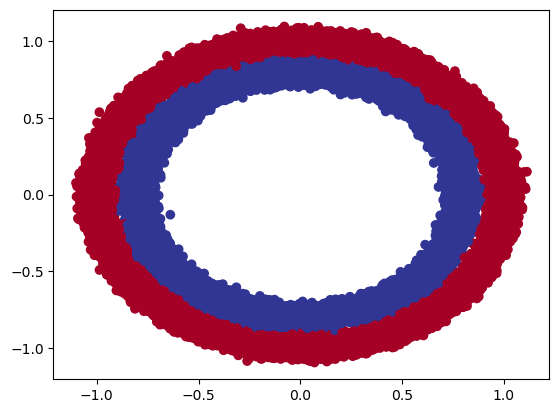

In [8]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

## Convert into tensors

In [9]:
X = torch.tensor(X)
X = X.type(torch.float32)

In [10]:
y = torch.tensor(y)
y = y.type(torch.float32)

In [11]:
X.shape, y.shape

(torch.Size([100000, 2]), torch.Size([100000]))

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([80000, 2]),
 torch.Size([20000, 2]),
 torch.Size([80000]),
 torch.Size([20000]))

In [14]:
X_train = X_train.to('cuda')
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

X_train.device

device(type='cuda', index=0)

In [15]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # self.layer1 = nn.Linear(2, 8)
        # self.layer2 = nn.Linear(8, 1)

        self.two_seq_layer = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.Linear(2, 1)
        )

    def forward(self, X):
        return self.two_seq_layer(X)


In [16]:
model = CircleModelV0()

model = model.to(device)
model

CircleModelV0(
  (two_seq_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=2, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [17]:
next(model.parameters()).device

device(type='cuda', index=0)

In [18]:
model.eval()

with torch.inference_mode():
    untrained_pred = model(X_test)

In [19]:
untrained_pred[:10], y_test[:10]

(tensor([[0.6423],
         [0.6094],
         [0.6410],
         [0.6487],
         [0.6072],
         [0.6214],
         [0.6490],
         [0.6423],
         [0.6069],
         [0.6097]], device='cuda:0'),
 tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 0.], device='cuda:0'))

In [20]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [21]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct/len(y_true)) * 100
    return accuracy

In [22]:
epochs = 3000

In [23]:
epoch_count = []
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

In [24]:
for epch in range(epochs):

    model.train()

    y_logits = model.forward(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # loss = loss_function(torch.sigmoid(y_logits), y_train) # would have been the code if the loss function was BCELoss
    loss = loss_function(model(X_train).squeeze(), y_train)
    train_loss.append(loss.item())

    accuracy_tr = accuracy_fn(y_train, y_pred) 
    train_accuracy.append(accuracy_tr)

    optimizer.zero_grad()

    loss.backward()
    
    optimizer.step()
    
    model.eval()

    with torch.inference_mode():
        test_loss.append(loss_function(model(X_test).squeeze(), y_test).item())
        accuracy_ts = accuracy_fn(y_test, torch.round(torch.sigmoid(model(X_test).squeeze())))
        test_accuracy.append(accuracy_ts)

    if (epch+1) % 100 == 0:
        print(f'Epoch {epch+1}/{epochs} : Train Loss {train_loss[-1]:.4f} : Test Loss {test_loss[-1]:.4f} : Train Accuracy {train_accuracy[-1]:.2f}% : Test Accuracy {test_accuracy[-1]:.2f}%')

Epoch 100/3000 : Train Loss 0.4563 : Test Loss 0.4471 : Train Accuracy 88.52% : Test Accuracy 89.22%
Epoch 200/3000 : Train Loss 0.0747 : Test Loss 0.0753 : Train Accuracy 99.80% : Test Accuracy 99.78%
Epoch 300/3000 : Train Loss 0.0385 : Test Loss 0.0392 : Train Accuracy 99.89% : Test Accuracy 99.85%
Epoch 400/3000 : Train Loss 0.0252 : Test Loss 0.0259 : Train Accuracy 99.90% : Test Accuracy 99.87%
Epoch 500/3000 : Train Loss 0.0184 : Test Loss 0.0191 : Train Accuracy 99.90% : Test Accuracy 99.87%
Epoch 600/3000 : Train Loss 0.0143 : Test Loss 0.0151 : Train Accuracy 99.91% : Test Accuracy 99.87%
Epoch 700/3000 : Train Loss 0.0116 : Test Loss 0.0125 : Train Accuracy 99.91% : Test Accuracy 99.87%
Epoch 800/3000 : Train Loss 0.0098 : Test Loss 0.0106 : Train Accuracy 99.92% : Test Accuracy 99.88%
Epoch 900/3000 : Train Loss 0.0084 : Test Loss 0.0093 : Train Accuracy 99.92% : Test Accuracy 99.88%
Epoch 1000/3000 : Train Loss 0.0074 : Test Loss 0.0083 : Train Accuracy 99.92% : Test Accur

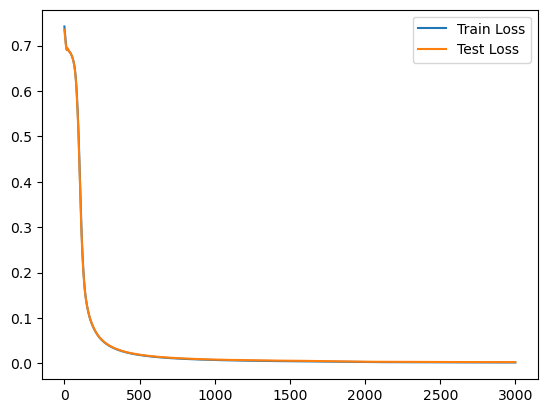

In [25]:
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()

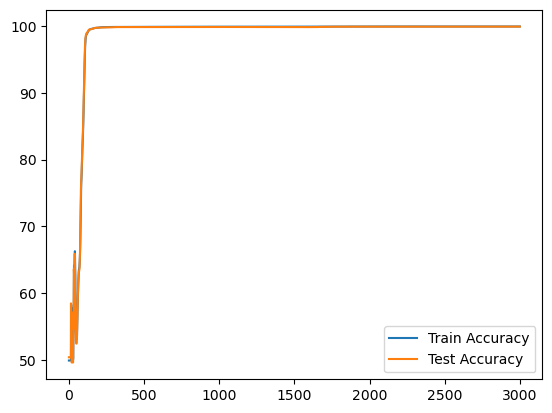

In [26]:
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.legend()

## Visualizing the Decision Boundary of the Model

In [27]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_function.py already exists")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "w") as file:
        file.write(request.text)

helper_function.py already exists


In [28]:
from helper_functions import plot_decision_boundary

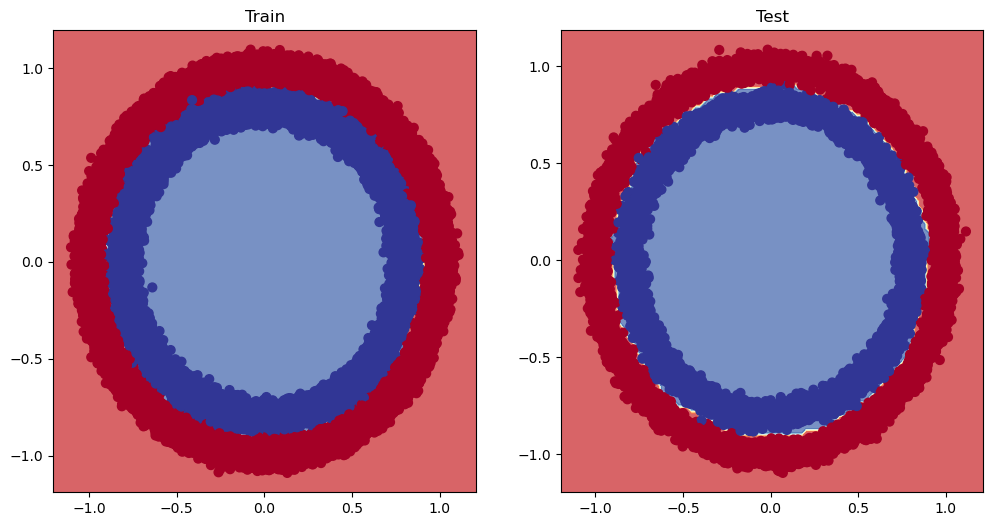

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X=X_test, y=y_test)